In [1]:
using Roots, NLsolve

Now we will do non-linear equation solving. Univariate and multivariate root-finding are actually in two different packages at the moment. Roots is univariate.

In [2]:
w = 3.
beta = 0.96
R = 1.01
alpha_h = 1.5
eulerfun(a) = 1/(w - a) - beta*R*1/(w + R*a)
eulerfun(0)

0.010133333333333328

In [3]:
ret = find_zero(eulerfun, 0)

-0.04606991311376025

Let's try the system of non-linear equations. We can make this a lot cleaner looking than the Matlab version.

In [4]:
function eulerfun(x)
    a, h1, h2 = x[1], x[2], x[3]
    out = zeros(3)
    c1 = w*h1 - a
    c2 = w*h2 + R*a
    (h1 >= 1 || h2 >= 1) && return Inf*out
    c1 <= 0 && return Inf*out
    out[1] = 1/c1 - beta*R*1/c2
    out[2] = w*1/c1 - alpha_h/(1 - h1)
    out[3] = w*1/c2 - alpha_h/(1 - h2)
    out
end
ret = nlsolve(eulerfun, [0; 0.5; 0.5]; inplace = false)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.5, 0.5]
 * Zero: [-0.0460699, 0.390786, 0.409306]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

The ;inplace = false argument in nlsolve is called a keyword argument. It tells nlsolve that eulerfun returns its array instead of mutating it in place. If you are solving a non-linear system with thousands of equations, you should mutate, but for our purposes this is easier.

The return Inf*out parts were not strictly neccesary, but again it is a good idea to handle implausible values manually. Other marginal utility functions might not have been defined for negative arguments.

It is common to define simple functions to make code even cleaner. Look at this

In [5]:
uc(c) = 1/c
uh(h) = alpha_h/(1 - h)
function eulerfun(x)
    a, h1, h2 = x[1], x[2], x[3]
    out = zeros(3)
    c1 = w*h1 - a
    c2 = w*h2 + R*a
    (h1 >= 1 || h2 >= 1) && return Inf*out
    c1 <= 0 && return Inf*out
    out[1] = uc(c1) - beta*R*uc(c2)
    out[2] = w*uc(c1) - uh(h1)
    out[3] = w*uc(c2) - uh(h2)
    out
end
ret = nlsolve(eulerfun, [0; 0.5; 0.5]; inplace = false)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.5, 0.5]
 * Zero: [-0.0460699, 0.390786, 0.409306]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

This is how you would write this problem on the board, and makes the economic intuition clear from the code. Also, this version is much easier to generalize. If your model's utility function changes, uc and uh are the only lines you need to update.

You should always try to do this. Your code will be much easier to read, debug, and modify if it looks like what you write on the board.

FYI, if you have your code in a big function, you can create nested functions which close over parameters. Example to generate the optimal solutions for various interest rates.

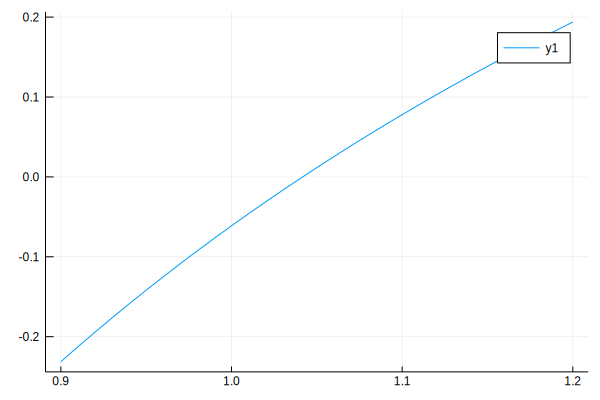

In [6]:
function test(rvec)
    w = 3.
    beta = 0.96
    assets = zeros(size(rvec))
    for i in eachindex(rvec)
        R = rvec[i]
        function eulerfun(x)
            a, h1, h2 = x[1], x[2], x[3]
            out = zeros(3)
            c1 = w*h1 - a
            c2 = w*h2 + R*a
            (h1 >= 1 || h2 >= 1) && return Inf*out
            c1 <= 0 && return Inf*out
            out[1] = uc(c1) - beta*R*uc(c2)
            out[2] = w*uc(c1) - uh(h1)
            out[3] = w*uc(c2) - uh(h2)
            out
        end
        ret = nlsolve(eulerfun, [0; 0.5; 0.5]; inplace = false)
        assets[i] = ret.zero[1]
    end
    assets
end
rvec = 0.9:0.01:1.2
assets = test(rvec)
using GR
plot(rvec, assets)

Above we defined the function test to take a vector input, rvec. This is fine, but a cleaner way to do it would be to just use the dot notation on a scalar version of the function. I do this below.

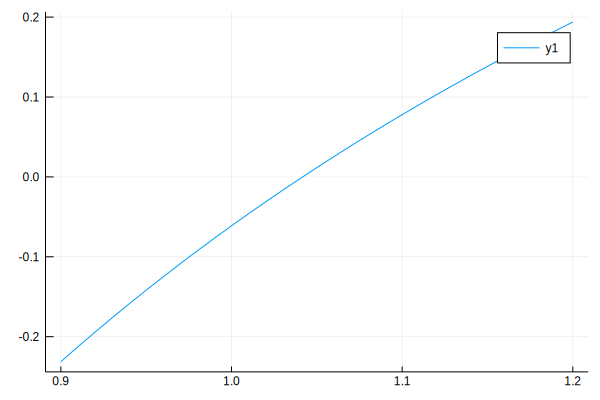

In [7]:
function test(R)
    w = 3.
    beta = 0.96
    function eulerfun(x)
        a, h1, h2 = x[1], x[2], x[3]
        out = zeros(3)
        c1 = w*h1 - a
        c2 = w*h2 + R*a
        (h1 >= 1 || h2 >= 1) && return Inf*out
        c1 <= 0 && return Inf*out
        out[1] = uc(c1) - beta*R*uc(c2)
        out[2] = w*uc(c1) - uh(h1)
        out[3] = w*uc(c2) - uh(h2)
        out
    end
    ret = nlsolve(eulerfun, [0; 0.5; 0.5]; inplace = false)
    assets = ret.zero[1]
end
rvec = 0.9:0.01:1.2
assets = test.(rvec)
plot(rvec, assets)